# Exploratory data analysis

In [3]:
from datasets import load_dataset
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

np.random.seed(42)

In [ ]:
# 1. Load the dataset (which already has train and test)
ds = load_dataset("ailsntua/QEvasion")

# 2. Encode the column for stratification (Crucial Step!)
# We only need to encode the train split since that's what we are dividing
ds['train'] = ds['train'].class_encode_column("evasion_label")

# 3. Split the existing 'train' into 'train' and 'validation'
# This creates a split of the 80% train into 80/20 (or whatever you prefer)
sub_split = ds['train'].train_test_split(
    test_size=0.2, 
    stratify_by_column="evasion_label", 
    seed=42
)

# 4. Assign everything to your variables
train_set = sub_split['train']
val_set   = sub_split['test']  # The 'test' result from this sub-split is your VAL
test_set  = ds['test']         # The original untouched test set

print(f"Final Setup:")
print(f"Train size: {len(train_set)}")
print(f"Val size:   {len(val_set)}")
print(f"Test size:  {len(test_set)}")

Casting to class labels:   0%|          | 0/3448 [00:00<?, ? examples/s]

Final Setup:
Train size: 2758
Val size:   690
Test size:  308


Loading QEvasion dataset...


/tmp/ipykernel_210438/348324494.py:50: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(y="evasion_label", data=df, order=order, palette="viridis")


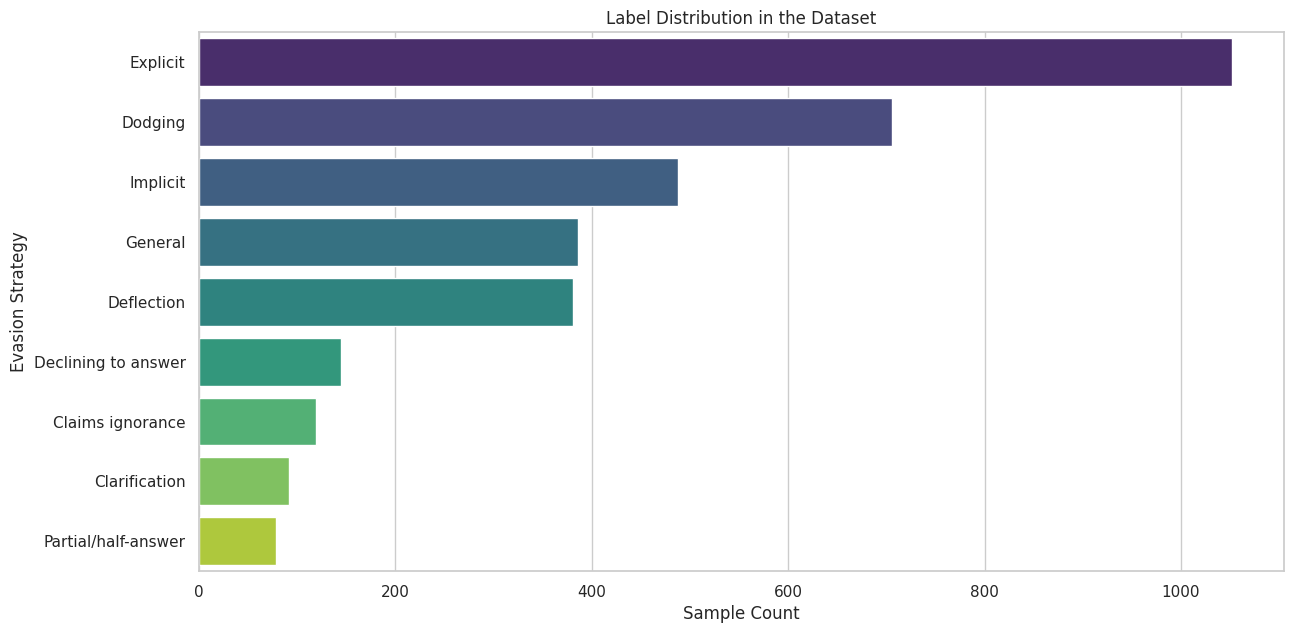

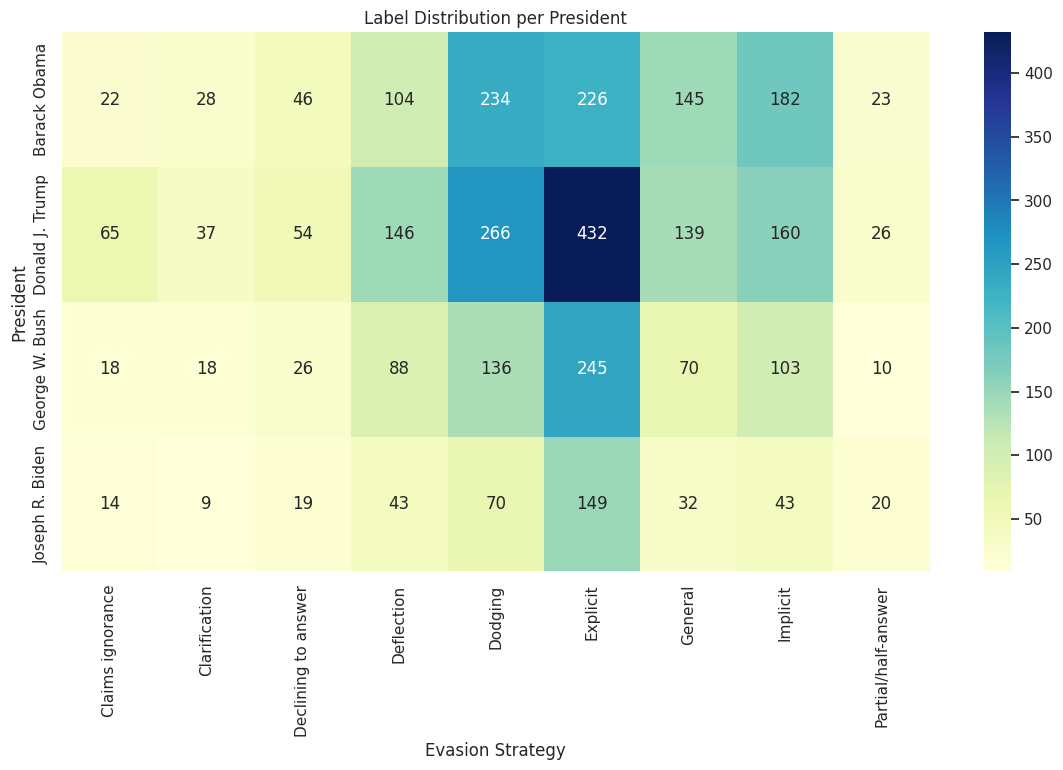

/tmp/ipykernel_210438/348324494.py:78: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  time_dist = df.groupby(["year", "month"]).size().unstack(fill_value=0)


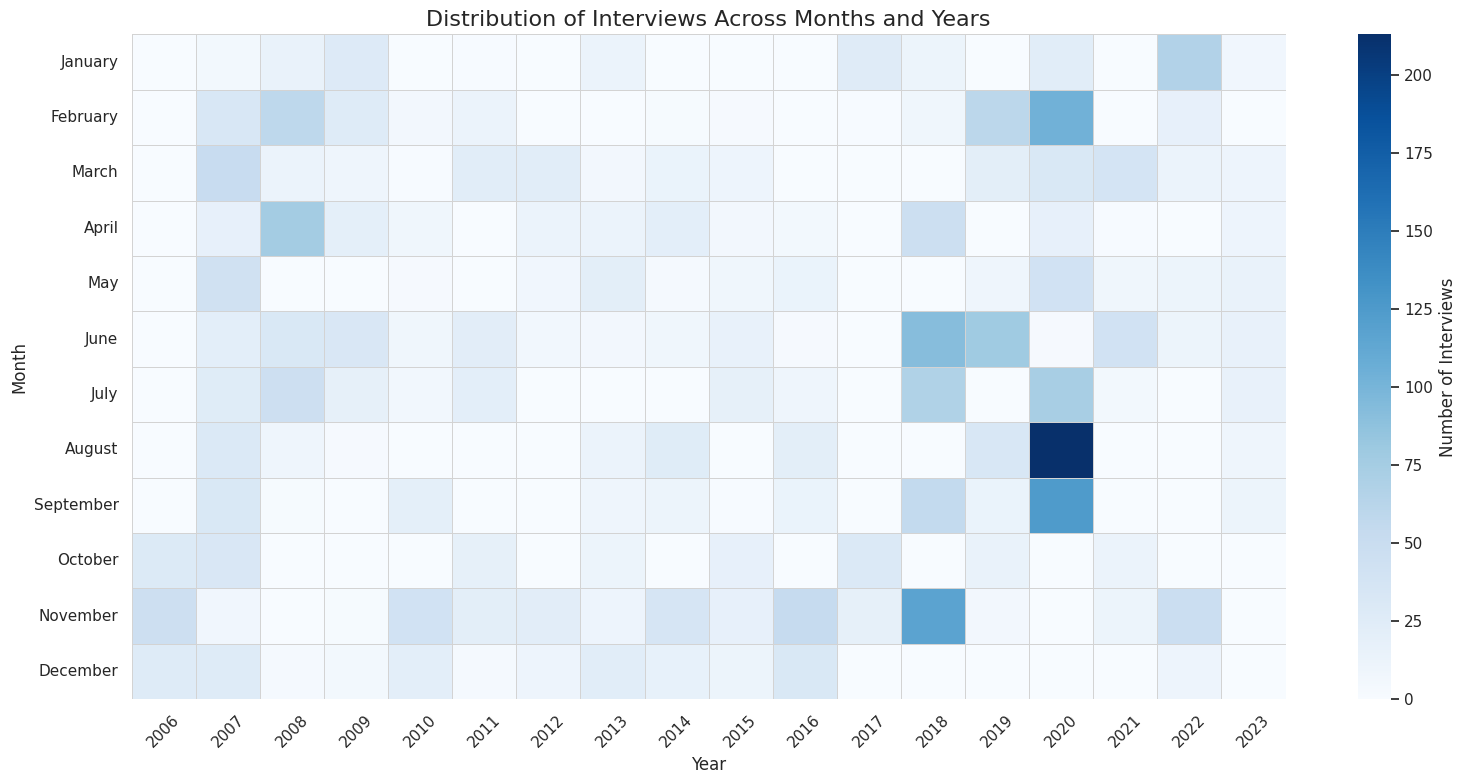

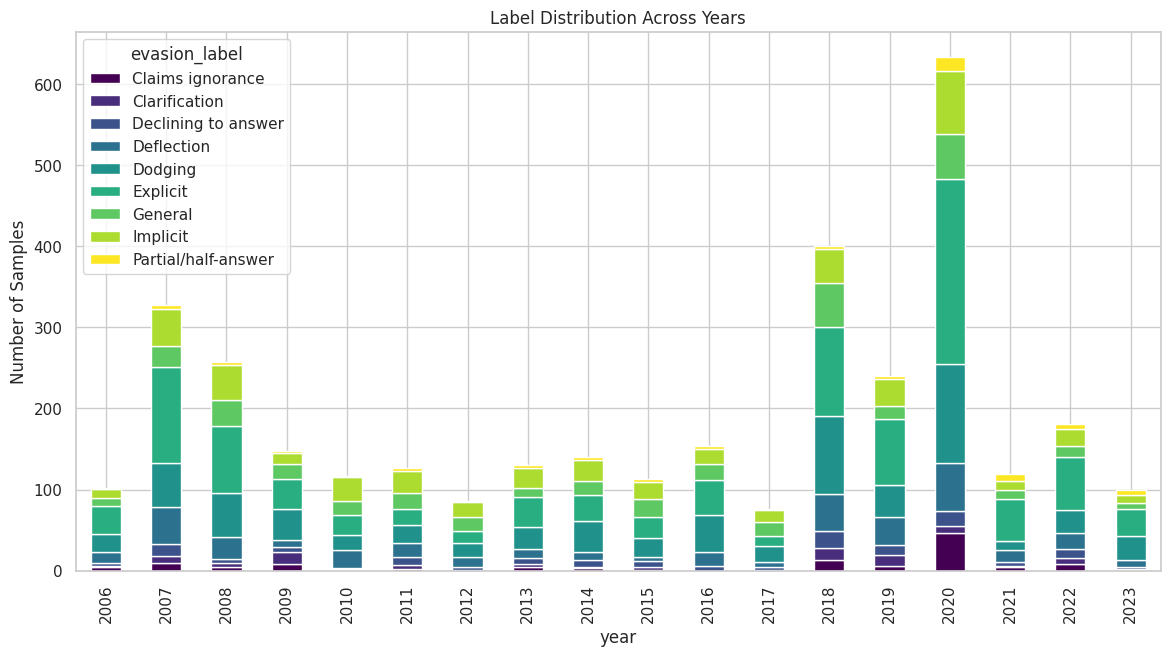

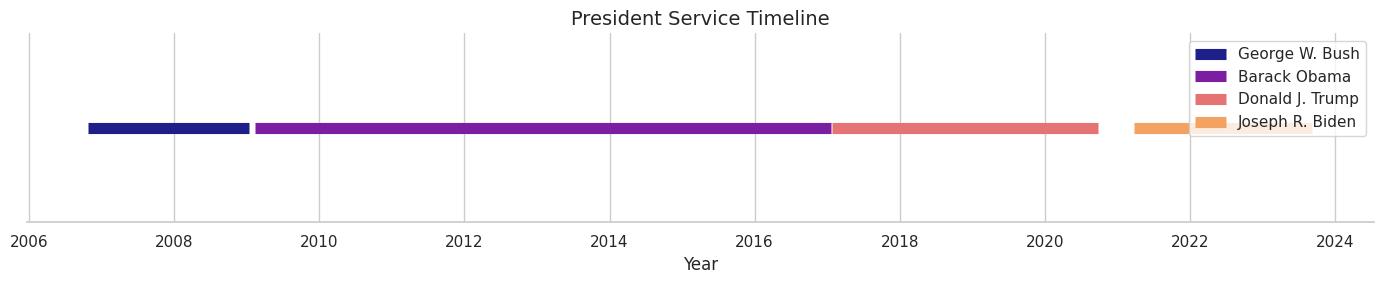

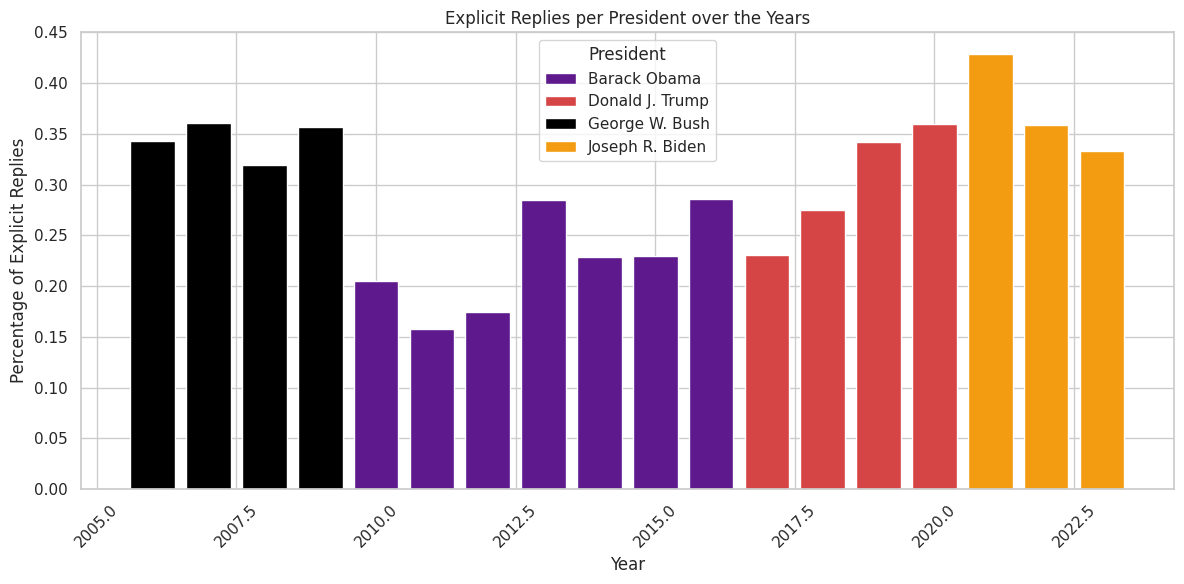

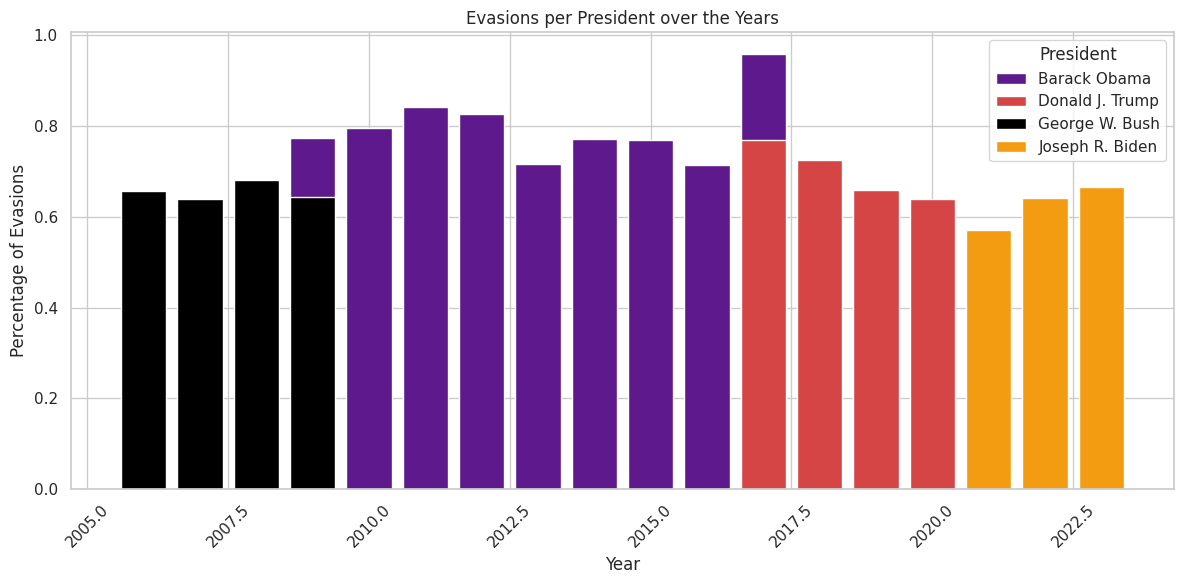

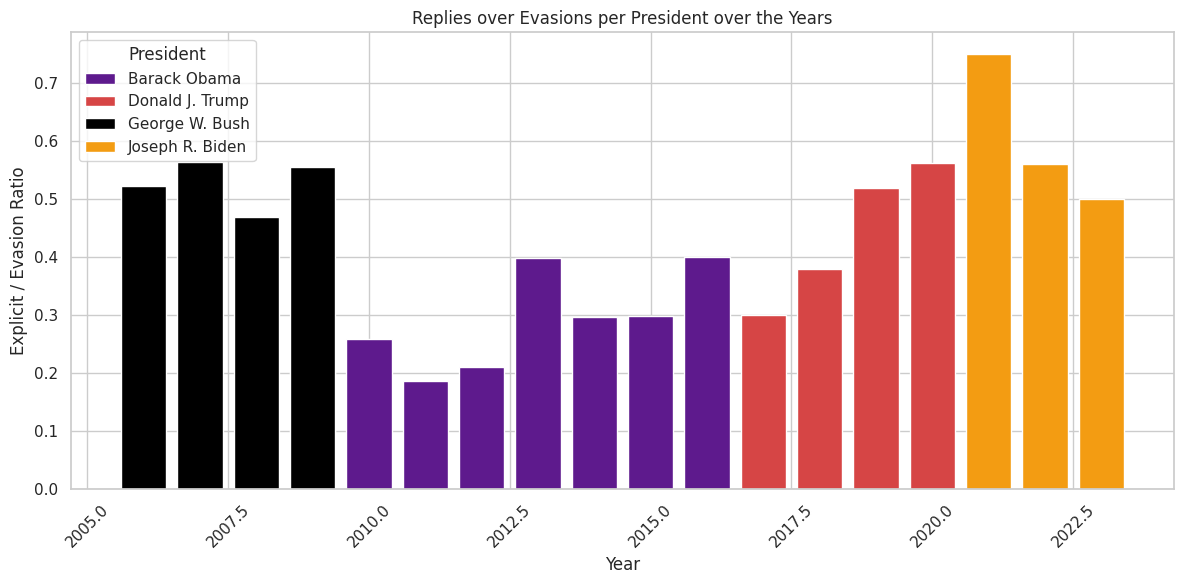

/tmp/ipykernel_210438/348324494.py:230: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x="sqa_per_q", data=df, palette="magma")


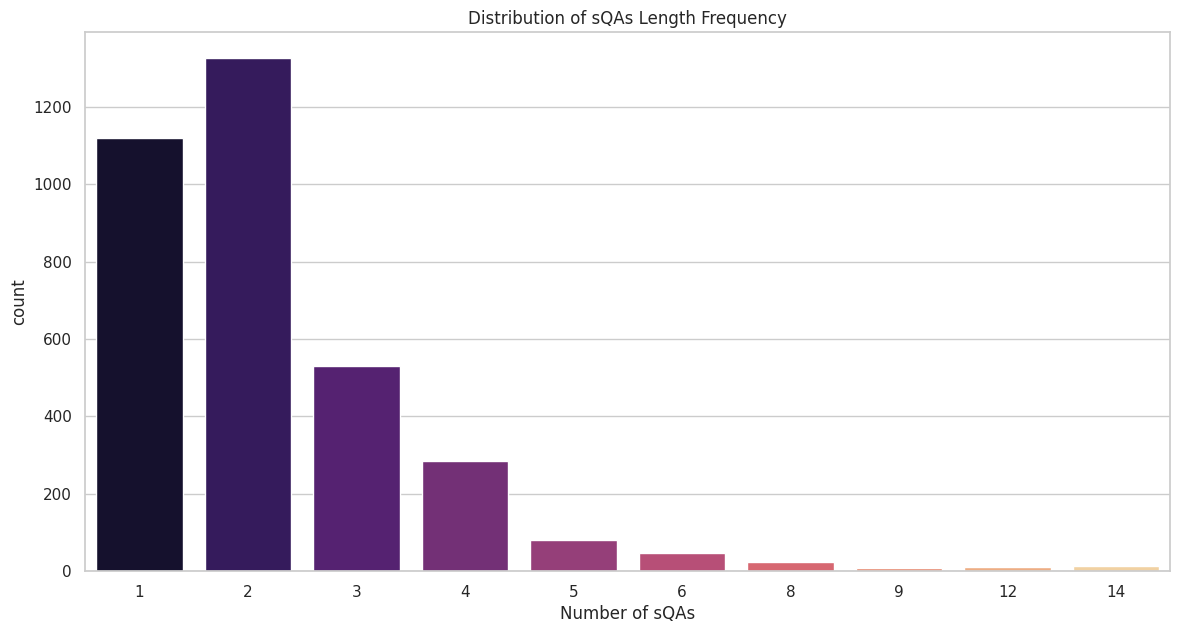

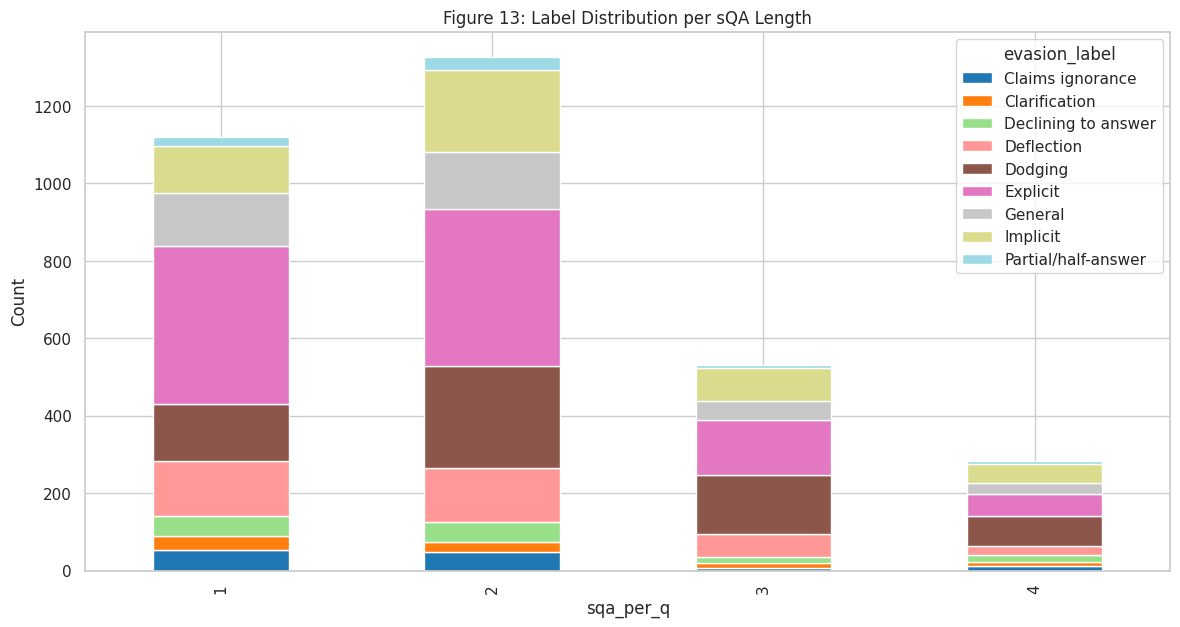

/tmp/ipykernel_210438/348324494.py:251: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=unique_q.index, y=unique_q.values, palette="coolwarm")


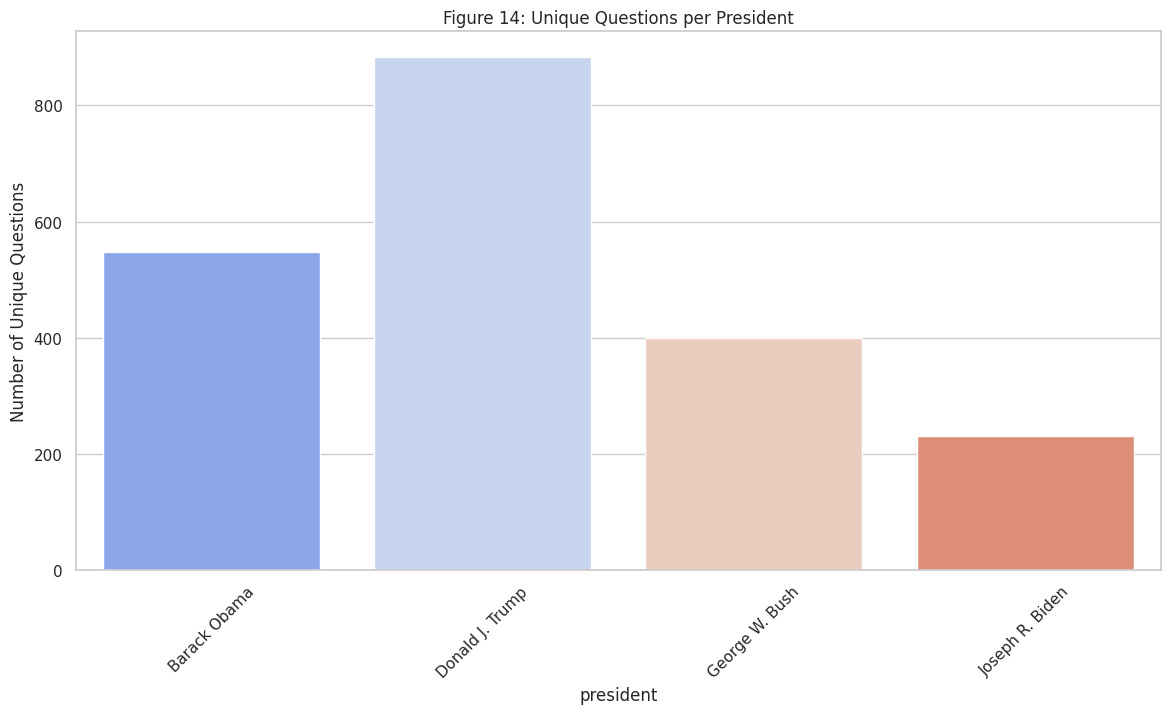

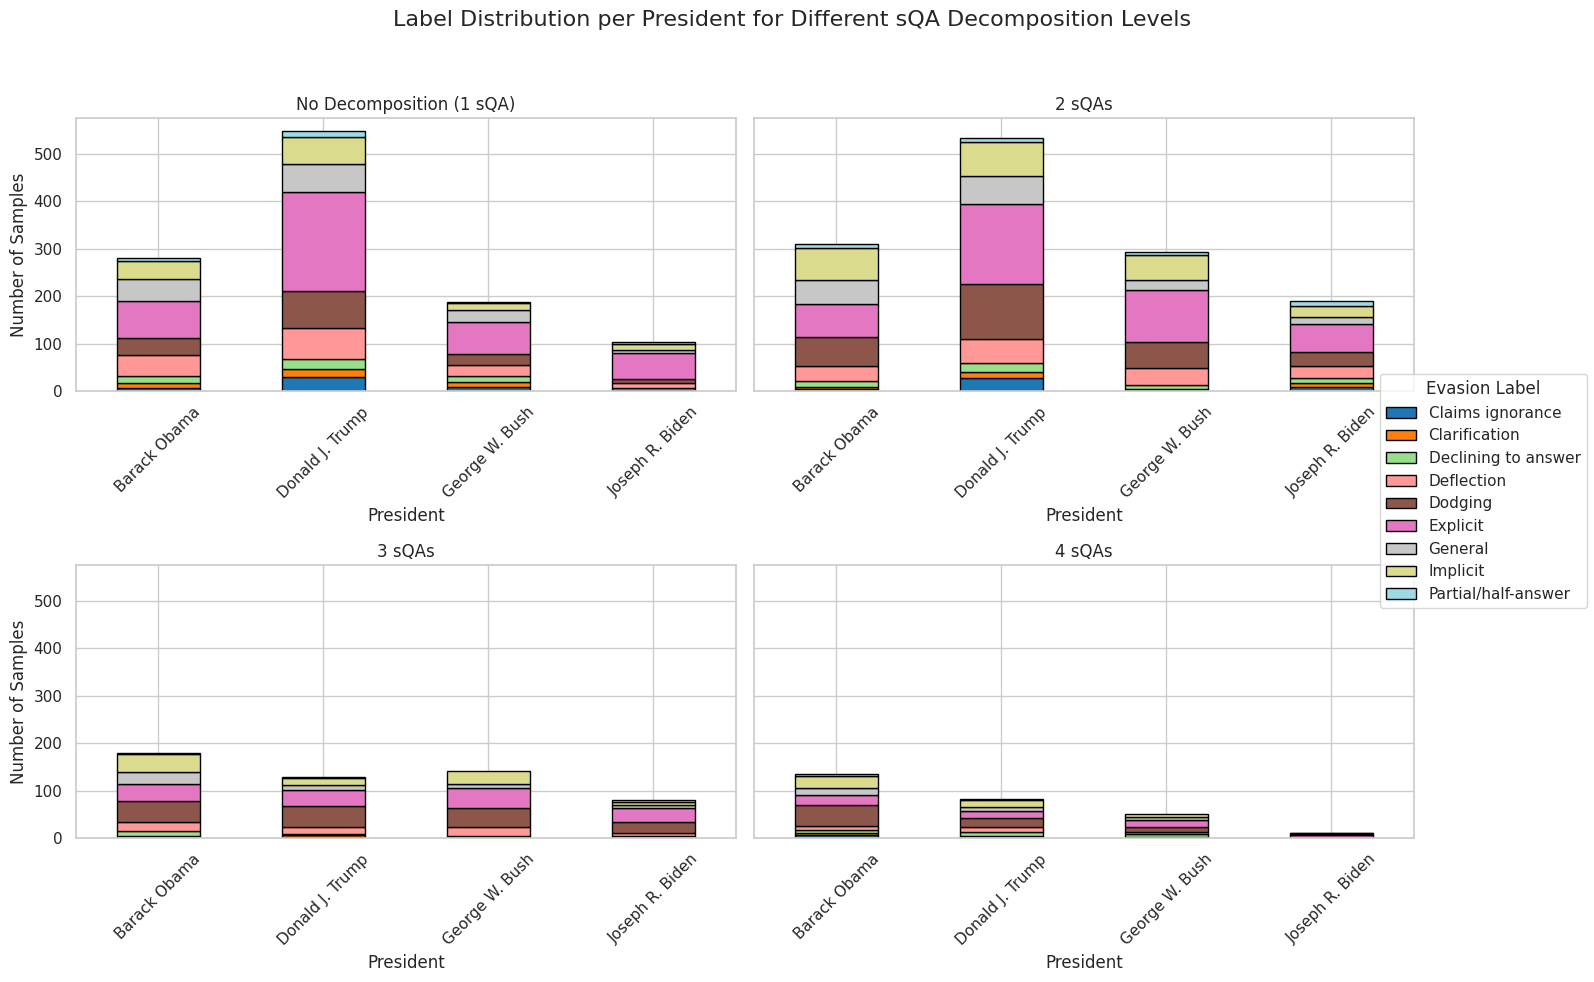

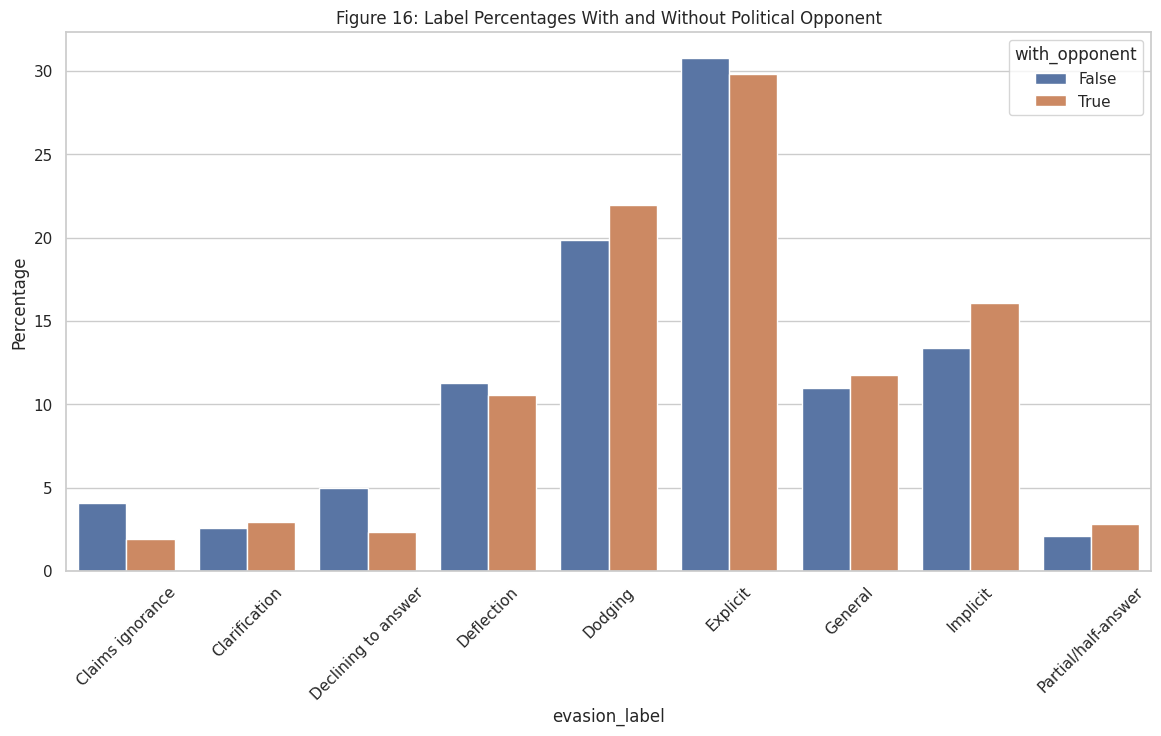

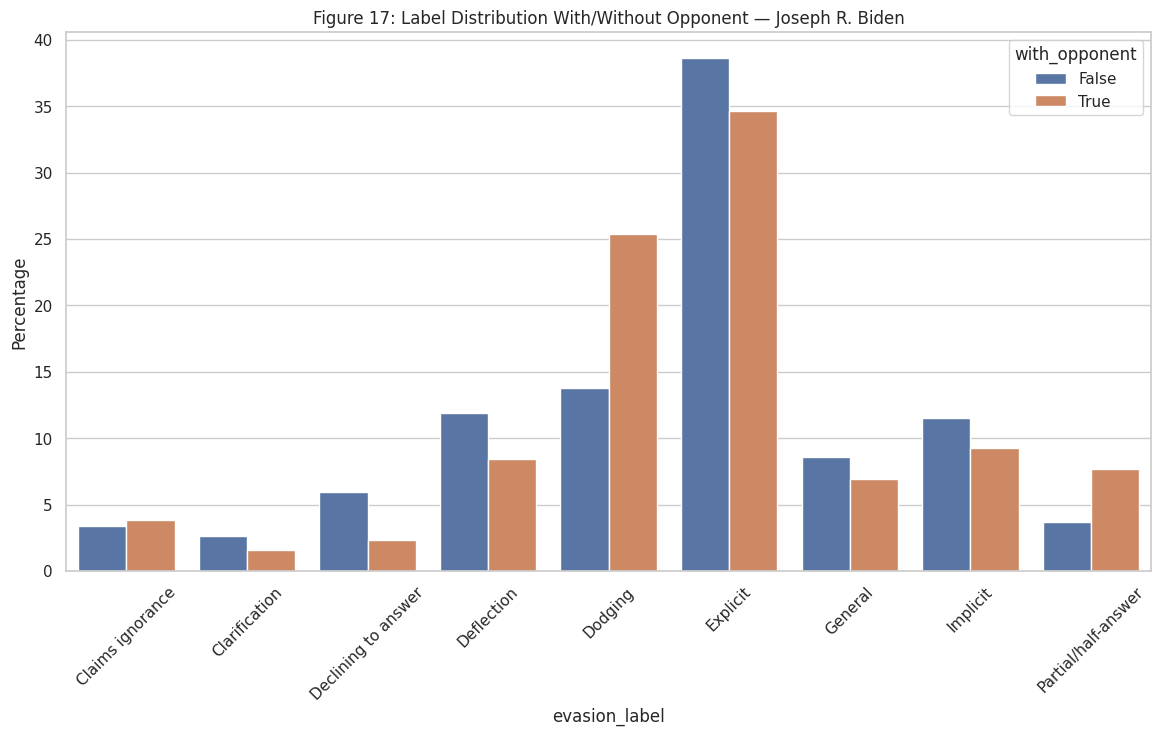

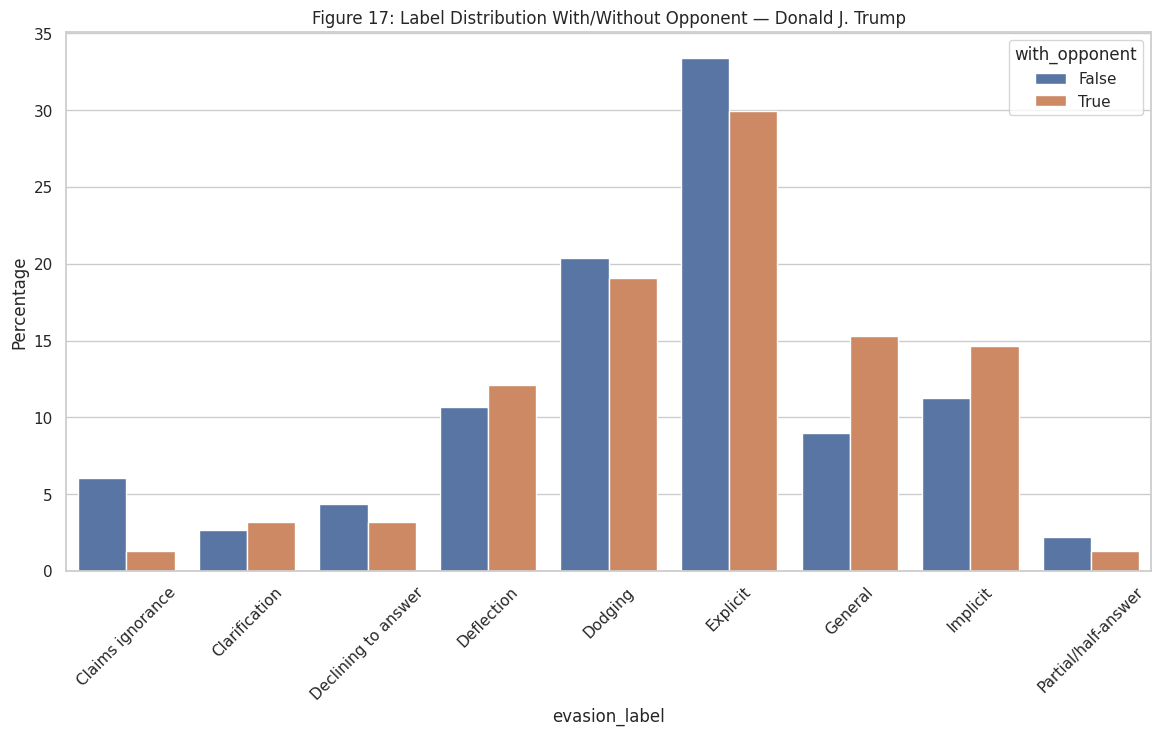

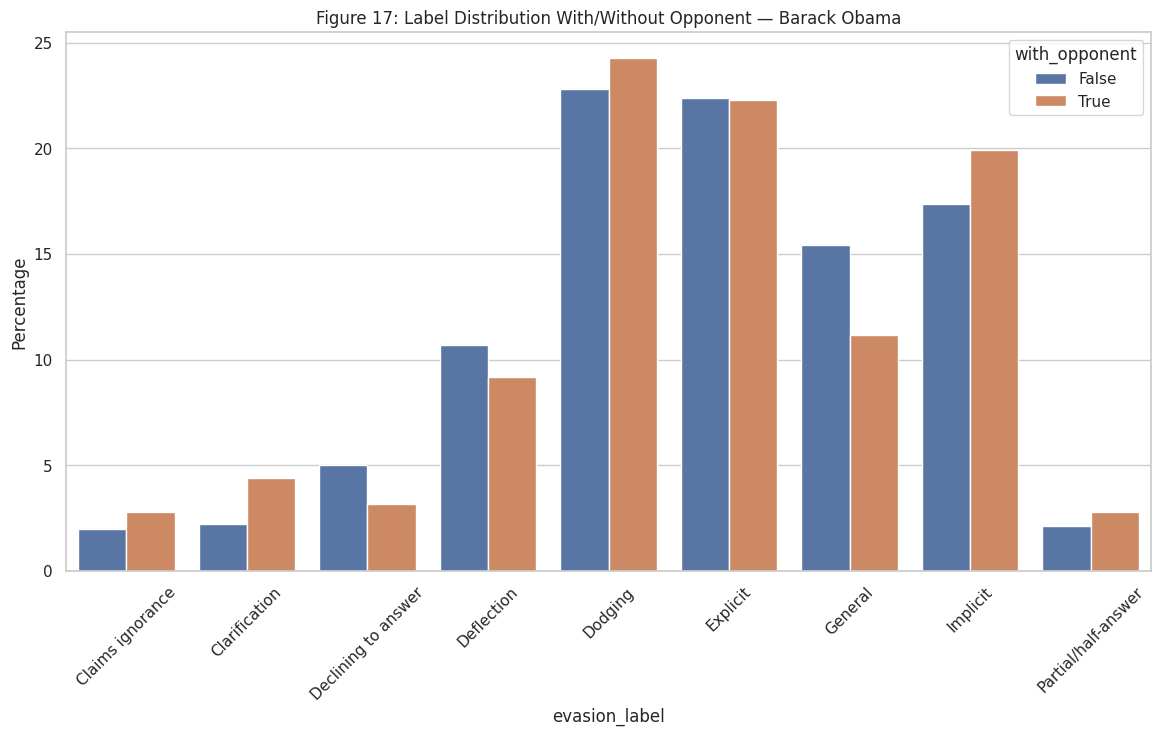

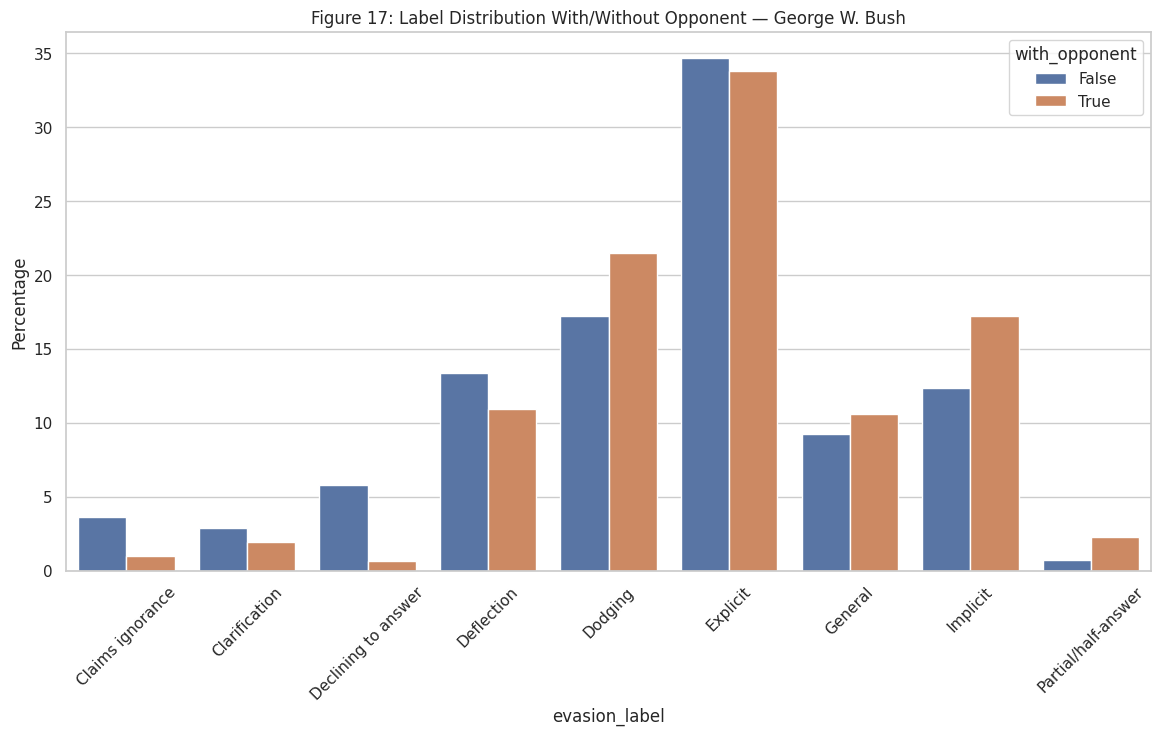

Complete EDA Analysis Finished Successfully.


In [ ]:
# ==========================================================
# 0. CONFIGURATION
# ==========================================================
sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (14, 7)

df = ds["train"].to_pandas()

# ==========================================================
# 1. PREPROCESSING
# ==========================================================
df["date"] = pd.to_datetime(df["date"], errors="coerce")
df["year"] = df["date"].dt.year
df["month"] = df["date"].dt.month_name()

# Clarity taxonomy (Level 1 grouping)
taxonomy_map = {
    'Explicit': 'Clear Reply',
    'Implicit': 'Ambivalent Reply',
    'Dodging': 'Ambivalent Reply',
    'General': 'Ambivalent Reply',
    'Deflection': 'Ambivalent Reply',
    'Partial/half-answer': 'Ambivalent Reply',
    'Declining to answer': 'Clear Non-Reply',
    'Claims ignorance': 'Clear Non-Reply',
    'Clarification': 'Clear Non-Reply'
}
df["clarity_label"] = df["evasion_label"].map(taxonomy_map)

# sQA decomposition count
sqa_counts = df.groupby("interview_question").size().reset_index(name="sqa_per_q")
df = df.merge(sqa_counts, on="interview_question")

# Opponent detection (proxy from title)
df["with_opponent"] = df["title"].fillna("").str.contains(" with | and ", case=False)

# ==========================================================
# FIGURE 1 — GLOBAL LABEL DISTRIBUTION
# ==========================================================
plt.figure()
order = df["evasion_label"].value_counts().index
sns.countplot(y="evasion_label", data=df, order=order, palette="viridis")
plt.title("Label Distribution in the Dataset")
plt.xlabel("Sample Count")
plt.ylabel("Evasion Strategy")
plt.show()

# ==========================================================
# FIGURE 2 — LABEL DISTRIBUTION PER PRESIDENT
# ==========================================================
label_pres = df.groupby(["president", "evasion_label"]).size().unstack(fill_value=0)
plt.figure()
sns.heatmap(label_pres, annot=True, fmt="d", cmap="YlGnBu")
plt.title("Label Distribution per President")
plt.ylabel("President")
plt.xlabel("Evasion Strategy")
plt.show()

# ==========================================================
# FIGURE 3 — INTERVIEW DISTRIBUTION ACROSS MONTHS & YEARS
# ==========================================================

month_order = [
    "January", "February", "March", "April", "May", "June",
    "July", "August", "September", "October", "November", "December"
]

df["month"] = pd.Categorical(df["month"], categories=month_order, ordered=True)

time_dist = df.groupby(["year", "month"]).size().unstack(fill_value=0)

time_dist = time_dist[month_order]

plt.figure(figsize=(16, 8))
sns.heatmap(
    time_dist.T,
    cmap="Blues",
    linewidths=0.5,
    linecolor="lightgray",
    cbar_kws={"label": "Number of Interviews"}
)

plt.title("Distribution of Interviews Across Months and Years", fontsize=16)
plt.xlabel("Year")
plt.ylabel("Month")
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


# ==========================================================
# FIGURE 4 — LABEL DISTRIBUTION ACROSS YEARS
# ==========================================================
year_labels = df.groupby(["year", "evasion_label"]).size().unstack(fill_value=0)
year_labels.plot(kind="bar", stacked=True, colormap="viridis")
plt.title("Label Distribution Across Years")
plt.ylabel("Number of Samples")
plt.show()

# ==========================================================
# FIGURE 5 — SERVICE TIMELINE PER PRESIDENT
# ==========================================================

service_period = df.groupby("president")["date"].agg(["min", "max"]).reset_index()

service_period = service_period.sort_values("min")

color_map = {
    "George W. Bush": "#1f1f8b",
    "Barack Obama": "#7b1fa2",
    "Donald J. Trump": "#e57373",
    "Joseph R. Biden": "#f4a261"
}

plt.figure(figsize=(14, 3))

for i, row in service_period.iterrows():
    pres = row["president"]
    start = row["min"]
    end = row["max"]
    
    plt.hlines(
        y=0,
        xmin=start,
        xmax=end,
        linewidth=8,
        color=color_map.get(pres, "gray"),
        label=pres
    )

plt.yticks([])
plt.xlabel("Year")
plt.title("President Service Timeline", fontsize=14)
sns.despine(left=True)
handles, labels = plt.gca().get_legend_handles_labels()
unique = dict(zip(labels, handles))
plt.legend(unique.values(), unique.keys(), loc="upper right")

plt.tight_layout()
plt.show()

# ==========================================================
# FIGURE 6 — TEMPORAL EVASION CHARACTERISTICS
# Three separate bar plots (Explicit, Evasions, Ratio)
# ==========================================================

pres_colors = {
    "George W. Bush": "black",
    "Barack Obama": "#5e1a8d",
    "Donald J. Trump": "#d64545",
    "Joseph R. Biden": "#f39c12"
}

df["is_explicit"] = (df["evasion_label"] == "Explicit").astype(int)
df["is_evasion"] = (df["evasion_label"] != "Explicit").astype(int)

yearly_stats = df.groupby(["president", "year"]).agg(
    explicit_rate=("is_explicit", "mean"),
    evasion_rate=("is_evasion", "mean")
).reset_index()

yearly_stats["reply_over_evasion"] = (
    yearly_stats["explicit_rate"] /
    yearly_stats["evasion_rate"]
)

def president_barplot(data, value_col, title, ylabel):
    plt.figure(figsize=(12,6))
    
    for pres in data["president"].unique():
        subset = data[data["president"] == pres]
        plt.bar(
            subset["year"],
            subset[value_col],
            color=pres_colors.get(pres, "gray"),
            label=pres
        )
    
    plt.title(title)
    plt.xlabel("Year")
    plt.ylabel(ylabel)
    plt.xticks(rotation=45)
    plt.legend(title="President")
    plt.tight_layout()
    plt.show()

# -----------------------------
# Plot 1 — Explicit Replies
# -----------------------------
president_barplot(
    yearly_stats,
    "explicit_rate",
    "Explicit Replies per President over the Years",
    "Percentage of Explicit Replies"
)

# -----------------------------
# Plot 2 — Evasions
# -----------------------------
president_barplot(
    yearly_stats,
    "evasion_rate",
    "Evasions per President over the Years",
    "Percentage of Evasions"
)

# -----------------------------
# Plot 3 — Replies / Evasions Ratio
# -----------------------------
president_barplot(
    yearly_stats,
    "reply_over_evasion",
    "Replies over Evasions per President over the Years",
    "Explicit / Evasion Ratio"
)

# ==========================================================
# FIGURE 7 — sQA LENGTH DISTRIBUTION
# ==========================================================
plt.figure()
sns.countplot(x="sqa_per_q", data=df, palette="magma")
plt.title("Distribution of sQAs Length Frequency")
plt.xlabel("Number of sQAs")
plt.show()

# ==========================================================
# FIGURE 8 — LABEL DISTRIBUTION PER sQA LENGTH
# ==========================================================
sqa_label = df[df["sqa_per_q"].isin([1,2,3,4])]
sqa_label_dist = sqa_label.groupby(["sqa_per_q", "evasion_label"]).size().unstack(fill_value=0)

sqa_label_dist.plot(kind="bar", stacked=True, colormap="tab20")
plt.title("Figure 13: Label Distribution per sQA Length")
plt.ylabel("Count")
plt.show()

# ==========================================================
# FIGURE 9 — UNIQUE QUESTIONS PER PRESIDENT
# ==========================================================
unique_q = df.groupby("president")["interview_question"].nunique()
plt.figure()
sns.barplot(x=unique_q.index, y=unique_q.values, palette="coolwarm")
plt.title("Figure 14: Unique Questions per President")
plt.ylabel("Number of Unique Questions")
plt.xticks(rotation=45)
plt.show()

# ==========================================================
# FIGURE 10 — sQA DECOMPOSITION PER PRESIDENT (4 PANELS)
# ==========================================================

sqa_levels = [1, 2, 3, 4]

fig, axes = plt.subplots(2, 2, figsize=(16, 10), sharey=True)
axes = axes.flatten()

for ax, sqa in zip(axes, sqa_levels):
    subset = df[df["sqa_per_q"] == sqa]
    
    dist = (
        subset
        .groupby(["president", "evasion_label"])
        .size()
        .unstack(fill_value=0)
    )
    
    dist.plot(
        kind="bar",
        stacked=True,
        ax=ax,
        colormap="tab20",
        edgecolor="black"
    )
    
    title = (
        "No Decomposition (1 sQA)"
        if sqa == 1
        else f"{sqa} sQAs"
    )
    ax.set_title(title)
    ax.set_xlabel("President")
    ax.set_ylabel("Number of Samples")
    ax.tick_params(axis="x", rotation=45)
    ax.legend_.remove()

handles, labels = axes[0].get_legend_handles_labels()
fig.legend(
    handles,
    labels,
    title="Evasion Label",
    loc="center right"
)

fig.suptitle(
    "Label Distribution per President for Different sQA Decomposition Levels",
    fontsize=16
)

plt.tight_layout(rect=[0, 0, 0.9, 0.95])
plt.show()


# ==========================================================
# FIGURE 11 — WITH/WITHOUT OPPONENT (GLOBAL)
# ==========================================================
opp_global = df.groupby(["with_opponent", "evasion_label"]).size()
opp_pct = (opp_global / opp_global.groupby(level=0).transform("sum") * 100).reset_index(name="percentage")

plt.figure()
sns.barplot(data=opp_pct, x="evasion_label", y="percentage", hue="with_opponent")
plt.title("Label Percentages With and Without Political Opponent")
plt.xticks(rotation=45)
plt.ylabel("Percentage")
plt.show()

# ==========================================================
# FIGURE 12 — WITH/WITHOUT OPPONENT PER PRESIDENT
# ==========================================================
for pres in df["president"].unique():
    sub = df[df["president"] == pres]
    opp_pres = sub.groupby(["with_opponent", "evasion_label"]).size()
    opp_pres_pct = (opp_pres / opp_pres.groupby(level=0).transform("sum") * 100).reset_index(name="percentage")
    
    plt.figure()
    sns.barplot(data=opp_pres_pct, x="evasion_label", y="percentage", hue="with_opponent")
    plt.title(f"Label Distribution With/Without Opponent — {pres}")
    plt.xticks(rotation=45)
    plt.ylabel("Percentage")
    plt.show()

print("Complete EDA Analysis Finished Successfully.")
